## Naive Risk Budgeting Strategies between the PSP and GHP

In [15]:
import numpy as np
import pandas as pd
import edhec_risk_kit as erk
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Let's create a function that provides us with the best mix for a stock-bond portfolio. As you can see, we have a function called "allocator" as a parameter, which is the responsible for finding the best weights for our portfolio. However, we have not yet developed a function that performs this task.

In [16]:
def bt_mix(r1,r2, allocator, **kwargs):
    
    """
    Runs a bak test (simulation) of allocating between a two sets of returns.
    r1 and r2 DataFrames or returns with the index as a time and N scenarios.
    "allocator" is a function that takes two sets of returns and allocator specific parameters,
    and produces and allocation to the first portfolio (the rest of the money is invested in GHP)
    as a DataFrame.
    Returns a DataFrame f the resulting N portfolio scenarios
    """
    
    if not r1.shape == r2.shape:
        raise ValueError("r1 and r2 need to be the same shape")
        
    weights = allocator(r1,r2,**kwargs)
    
    if not weights.shape == r1.shape:
        raise ValueError("Allocator returned weights that dont match r1")
        
    r_mix = weights*r1 + (1-weights)*r2
    
    return r_mix 

Let's write now one possible allocator:

In [17]:
def fixedmix_allocator(r1,r2,w1,**kwargs):
    
    """
    Produces a time series over T steps of allocations between the PSP and GHP across N scenarios.
    PSP and GHP are DataFrames that represent the returns of the PSP and GHP such that:
         each column is a scenario
         each row is the price for a timestep
    Returns a DataFrame of PSP Weights
    """
    
    #Weight is fixed for any time, so it will return an r1 (or r2, it is the same) shaped
    #DataFrame with value w1 in all positions 
    
    return pd.DataFrame(data=w1, index=r1.index,columns=r1.columns) #r1 and r2 index and columns should be the same
    

Let's  bring back some code we wrote in the previous notebook:

In [22]:
rates, zc_prices = erk.cir(10,500,b=0.03,r_0=0.03)
price_10 = erk.bond_price(10,100,.05,12,rates)
price_30 = erk.bond_price(10,100,.05,12,rates)
rets_10 = erk.bond_total_return(price_10,100,0.05,12)
rets_30 = erk.bond_total_return(price_30,100,0.05,12)
rets_zc = zc_prices.pct_change().dropna() #returns of zero coupon bond. We can do it like this because it
#does not give payouts/coupons.


Let's put to use our new functions by doing a mix of the two bonds:

In [23]:
rets_bond = erk.bt_mix(rets_10,rets_30,allocator=erk.fixedmix_allocator,w1=0.6) #
mean_rets_bonds = rets_bond.mean(axis='columns')
erk.summarize_stats(pd.DataFrame(mean_rets_bonds))

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Cornish-Fisher CVaR,Sharpe Ratio
0,0.03182,0.003404,0.493848,4.446873,-0.001175,-0.000911,0.52031


We should now generate some stocks as we did in notebook 5 as well:

In [24]:
price_eq = erk.gbm(n_years=10,n_scenarios=500,mu=0.07,sigma=0.15)
rets_eq = price_eq.pct_change()
rets_eq.iloc[0] = 0 #first row is returned as a NaN. We should set it to 0, as there is no return.


And let's mix the bond mix with the stocks:

In [25]:
rets_7030 = erk.bt_mix(rets_eq,rets_bond,allocator=erk.fixedmix_allocator,w1=0.7)
rets_7030_mean = rets_7030.mean(axis=1)
erk.summarize_stats(pd.DataFrame(rets_7030_mean))

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Cornish-Fisher CVaR,Sharpe Ratio
0,0.058915,0.004715,-0.268924,3.696007,-0.002551,-0.001978,6.075209


So you can see that the return is much better, and so is the Sharpe Ratio.

We can also compute the summary stats for each scenario, and the compute the mean of these stats. Of, course this takes more time, but having the stats in all periods might be more meaningful than just having the average stats. However, the mean of the stats of each scenario is different from the stats given by the mean return.

In [26]:
summaries = erk.summarize_stats(rets_7030)
summaries.mean()


Annualized Return          0.053816
Annualized Vol             0.105246
Skewness                   0.008035
Kurtosis                   2.988881
Cornish-Fisher VaR (5%)    0.044806
Cornish-Fisher CVaR        0.057994
Sharpe Ratio               0.226253
dtype: float64

Let's create another function for some other stats:

In [27]:
def terminal_stats(rets,floor=0.8,cap=np.inf,name="Stats"):
    
    """
    Produce Summary Statistics on the terminal values per invested dollar across
    a range of N scenarios.
    rets is a DataFrame with returns, with time as index.
    Returns a 1 row DataFrame of Summary Stats:
    p_breach: percentage of floor breaches
    e_breach: mean of the breach value
    p_reach: percentage of cap reaches
    e_reach: mean of the reach value
    
    """
    
    terminal_wealth = (rets+1).prod()
    breach = terminal_wealth < floor
    reach = terminal_wealth >= cap
    p_breach = breach.mean() if breach.sum() > 0 else np.nan #percentage of breaches
    p_reach = reach.mean() if reach.sum() > 0 else np.nan
    e_short = (floor - terminal_wealth[breach]).mean() if breach.sum() > 0 else np.nan #only proceeds when breach==True
    e_surplus = (cap-terminal_wealth[reach]).mean() if reach.sum() > 0 else np.nan
    sum_stats = pd.DataFrame({"Mean": [terminal_wealth.mean()],
                             "STD": [terminal_wealth.std()],
                             "P_breach": [p_breach],
                             "E_short": [e_short],
                             "P_reach": [p_reach],
                             "E_surplus": [e_surplus]},
                            index = [name])

    return sum_stats

In [29]:
pd.concat([erk.terminal_stats(rets_bond,name="Bonds"),erk.terminal_stats(rets_eq,name="Equities"),erk.terminal_stats(rets_7030, name="70/30 mix")])

,Mean,STD,P_breach,E_short,P_reach,E_surplus
Bonds,1.355417,0.030567,NaN,NaN,NaN,NaN
Equities,2.022316,1.023966,0.050,0.127463,NaN,NaN
70/30 mix,1.790096,0.627397,0.012,0.116704,NaN,NaN


So you can see that with bonds, you _never_ breach the floor, and with a 70/30 mix, the probability is absurd. A full equity portfolio does not have a really big percentage of breach, and it has a return of 2 dollars per dollar invested in 10 years, so it might be worth taking the risk. Let's now do some plotting with a package we have not used until now to see how the terminal returns for the different mixes are distributed

C:\Users\jackt\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\jackt\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\jackt\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

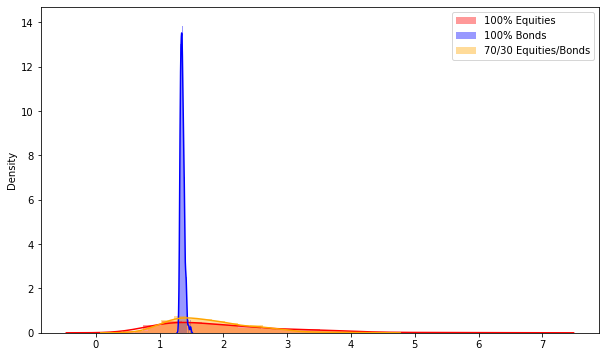

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.distplot(erk.terminal_values(rets_eq),color="red",label=("100% Equities"))
sns.distplot(erk.terminal_values(rets_bond),color="blue",label=("100% Bonds"))
sns.distplot(erk.terminal_values(rets_7030),color="orange",label=("70/30 Equities/Bonds"))
plt.legend()


As you can see, the more equities we have, the flatter the distribution is. On the other hand, with bonds, we have an extremely high peak.

### Glide Paths for Allocation

Instead of having fixed weights, what we can do is set dynamics weights. This way, we could start with a portfolio with a high equity weight and end with a portfolio which is mainly comprised of bonds. This allows us to take more risk in the beginning, where we still have time to recover from losses, but also protect ourselves from severe losses when it is time to match liabilities. The following function sets a starting weight and final weight for the equities (and consequently for the bonds), and changes it in each period by the same amount ($\frac{w_{f}-w_{s}}{\# periods}$)

In [31]:
def glidepath_allocator(r1,r2,start_glide=1,end_glide=0):
    
    """
    Simulates a Target-Date-Fund style gradual move from r1 to r2
    Goes from weight 1 (start_glide) to weight 0 (end_glide) as default
    """
    
    
    n_points = r1.shape[0]
    n_col = r1.shape[1]
    path = pd.Series(data=np.linspace(start_glide,end_glide,n_points))
    paths = pd.concat([path]*n_col,axis=1) #we have n_col scenarios, and all of them follow the same path.
    #This way we have n_col columns (one for each scenario) with the same path. Concatenating with axis=1
    #is important. In order to understand, try the following: pd.concat([pd.Series([2,3])]*2,axis=1)
    paths.index = r1.index
    paths.columns = r1.columns
    return paths

In [32]:
rets_g8020 = erk.bt_mix(rets_eq,rets_bond, allocator=erk.glidepath_allocator,start_glide=.80,end_glide=.20)

In [33]:
pd.concat([erk.terminal_stats(rets_bond,name="Bonds"),
           erk.terminal_stats(rets_eq,name="Equities"),
           erk.terminal_stats(rets_7030, name="70/30 mix"),
           erk.terminal_stats(rets_g8020,name="Glide 80 to 20")])

,Mean,STD,P_breach,E_short,P_reach,E_surplus
Bonds,1.355417,0.030567,NaN,NaN,NaN,NaN
Equities,2.022316,1.023966,0.050,0.127463,NaN,NaN
70/30 mix,1.790096,0.627397,0.012,0.116704,NaN,NaN
Glide 80 to 20,1.644712,0.431485,0.004,0.039335,NaN,NaN
